In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
train = pd.read_csv("../input/train.csv",parse_dates=["Dates"])
test = pd.read_csv("../input/test.csv",parse_dates=["Dates"],index_col='Id') #test에만 id값이 있어서 유니크한 값이니 index로 해주자

In [ ]:
test.info() # 87만개 데이터 - 칼럼 추가한다고 성능 떨어지지 않아!

In [ ]:
train.shape

In [ ]:
train.isnull().sum() #결측치확인
# 아웃라이어를 없애는 건 회귀문제에서 주로 함 (분류에서는 잘 안해요..)

In [ ]:
train.tail(10)

In [ ]:
test.sample(10)

In [ ]:
#date를 나누는 이유? - 모델이 학습을 못하는 날짜데이터라서 모델에 쓰기 위해서 나눕니다.

train['Day'] = train['Dates'].dt.day
train['DayOfWeek'] = train['Dates'].dt.weekday
train['Month'] = train['Dates'].dt.month
train['Year'] = train['Dates'].dt.year
train['Hour'] = train['Dates'].dt.hour
train['Minute'] = train['Dates'].dt.minute

test['Day'] = test['Dates'].dt.day
test['DayOfWeek'] = test['Dates'].dt.weekday
test['Month'] = test['Dates'].dt.month
test['Year'] = test['Dates'].dt.year
test['Hour'] = test['Dates'].dt.hour
test['Minute'] = test['Dates'].dt.minute

In [43]:
#주소의 자세한 정보 추가해주기
#contains는 포함하면 True 아니면 False 나오게 하는 함수, case=False는 대소문자 구분을 없애겠다는 뜻.

train['Block'] = train['Address'].str.contains('block', case=False).apply(lambda x: 1 if x == True else 0)
train['ST'] = train['Address'].str.contains('ST', case=False).apply(lambda x: 1 if x == True else 0)
train['AV'] = train['AV'].str.contains('av', case=False).apply(lambda x :1 if x==True else 0)

test['Block'] = test['Address'].str.contains('block', case=False).apply(lambda x: 1 if x == True else 0)
test['ST'] = test['Address'].str.contains('ST', case=False).apply(lambda x: 1 if x == True else 0)
test['AV'] = test['AV'].str.contains('av', case=False).apply(lambda x :1 if x==True else 0)

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [ ]:
train.head() # 숫자데이터가 아닌 것들은 숫자로 바꿔주자

In [ ]:
# 숫자로 바꾸기-> 유니크한 값으로 대응시켜서 만들어보자
#유니크 값 확인하기
train["PdDistrict"].nunique()

In [ ]:
#칼럼별로 유니크한 값 넣어주기
train.nunique()

In [ ]:
# 그냥 정수값 대입시키면 서로 의미 없는 것에 의미를 부여하므로 
# 원핫 인코딩을 해보자 - 꼭 필요한 경우가 아니면 하지 말자. #트리모델 말고 다른 모델 쓸 때 (선형, knn, 인공신경망 등 거리가 중요한 모델 쓸 때는 써야함.)
# 카테고리형 변수를 가장 잘 처리하는 catboost (lgbm보다 더 잘 처리함) - 진짜 잘나옵니다.
# 원핫 인코딩의 단점 - 데이터가 크면 거의 불가능 너무 느려지고, 차원의 저주 발생
# 원핫 인코딩이 꼭 필요한 경우? 
# 트리모델을 사용하면 정수를 부여해도 순서에 의미를 두지 않기 때문에 써도 돼 !!!
# 트리모델 쓸 꺼니까 라벨 인코딩을 합시다.
# 라벨 인코딩하면 알아서 정수값으로 대입해줍니다.




In [27]:
#Label Encode

#Pd district를 변환합시다.

#모델 가져오기
from sklearn.preprocessing import LabelEncoder
#모델 선언하기(만들기)
le1 = LabelEncoder()
#모델에 데이터로 fitting해주기
#fit은 알고리즘을 등록만
#transform 은 fit을 참고하여 대입, 값을 만들어 냄

#fit, transform같이 해버리기
train['PdDistrict'] = le1.fit_transform(train['PdDistrict'])
test['PdDistrict'] = le1.transform(test['PdDistrict'])


In [28]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Day,Month,Year,Hour,Minute
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,2,4,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,13,5,2015,23,53
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,2,4,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,13,5,2015,23,53
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,2,4,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,13,5,2015,23,33
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,2,4,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,13,5,2015,23,30
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,2,5,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,13,5,2015,23,30


In [30]:
#train과 test에 있는 모든 주소를 대입하기 위해서 train+test 합쳐서 fit 시켜줍니다

le3 = LabelEncoder()
le3.fit(list(train['Address']) + list(test['Address']))
train['Address'] = le3.transform(train['Address'])
test['Address'] = le3.transform(test['Address'])

In [33]:
le2 = LabelEncoder()
y= le2.fit_transform(train['Category'])

In [44]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Day,Month,Year,Hour,Minute,Date,n_days,X_Y,XY
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,2,4,"ARREST, BOOKED",20895,-122.425892,37.774599,13,5,2015,23,53,2015-05-13,4510,-160.200490,-84.651293
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,2,4,"ARREST, BOOKED",20895,-122.425892,37.774599,13,5,2015,23,53,2015-05-13,4510,-160.200490,-84.651293
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,2,4,"ARREST, BOOKED",24169,-122.424363,37.800414,13,5,2015,23,33,2015-05-13,4510,-160.224777,-84.623949
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,2,4,NONE,4418,-122.426995,37.800873,13,5,2015,23,30,2015-05-13,4510,-160.227868,-84.626123
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,2,5,NONE,1923,-122.438738,37.771541,13,5,2015,23,30,2015-05-13,4510,-160.210279,-84.667196


In [35]:
#1 block, av 등 구분해주면 더 잘 분류할 것 (도메인 정보)
#2 지금으로부터 얼마나 과거에 자주 일어나던 데이터인지 파생 변수 만들어주기

In [36]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Day,Month,Year,Hour,Minute,Date
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,2,4,"ARREST, BOOKED",20895,-122.425892,37.774599,13,5,2015,23,53,2015-05-13
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,2,4,"ARREST, BOOKED",20895,-122.425892,37.774599,13,5,2015,23,53,2015-05-13
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,2,4,"ARREST, BOOKED",24169,-122.424363,37.800414,13,5,2015,23,33,2015-05-13
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,2,4,NONE,4418,-122.426995,37.800873,13,5,2015,23,30,2015-05-13
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,2,5,NONE,1923,-122.438738,37.771541,13,5,2015,23,30,2015-05-13


In [ ]:
#파생변수 만들어주기 위해 만듦
train['Date'] = (train['Dates'].dt.date).astype("datetime64")

In [50]:
test.head()

,Dates,DayOfWeek,PdDistrict,Address,X,Y,Day,Month,Year,Hour,Minute,Date,n_days
Id,,,,,,,,,,,,,
0,2015-05-10 23:59:00,6,0,6626,-122.399588,37.735051,10,5,2015,23,59,2015-05-10,4512
1,2015-05-10 23:51:00,6,0,10069,-122.391523,37.732432,10,5,2015,23,51,2015-05-10,4512
2,2015-05-10 23:50:00,6,4,6553,-122.426002,37.792212,10,5,2015,23,50,2015-05-10,4512
3,2015-05-10 23:45:00,6,2,10985,-122.437394,37.721412,10,5,2015,23,45,2015-05-10,4512
4,2015-05-10 23:45:00,6,2,10985,-122.437394,37.721412,10,5,2015,23,45,2015-05-10,4512


In [49]:
test['Date'] = (test['Dates'].dt.date).astype("datetime64")
test['n_days'] = (test['Date'] - test['Date'].min()).apply(lambda x: x.days)

KeyError: 'Category'

In [37]:
#우리가 갖고 있는 최초의 날짜로부터 몇 일이 지났는가(date는 숫자값이 아니므로 숫자값으로 변경해줍니다.)
#apply(lambda x: x.days) - x.days라는 함수를 적용하자

train['n_days'] = (train['Date'] - train['Date'].min()).apply(lambda x: x.days)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]), <a list of 39 Text xticklabel objects>)

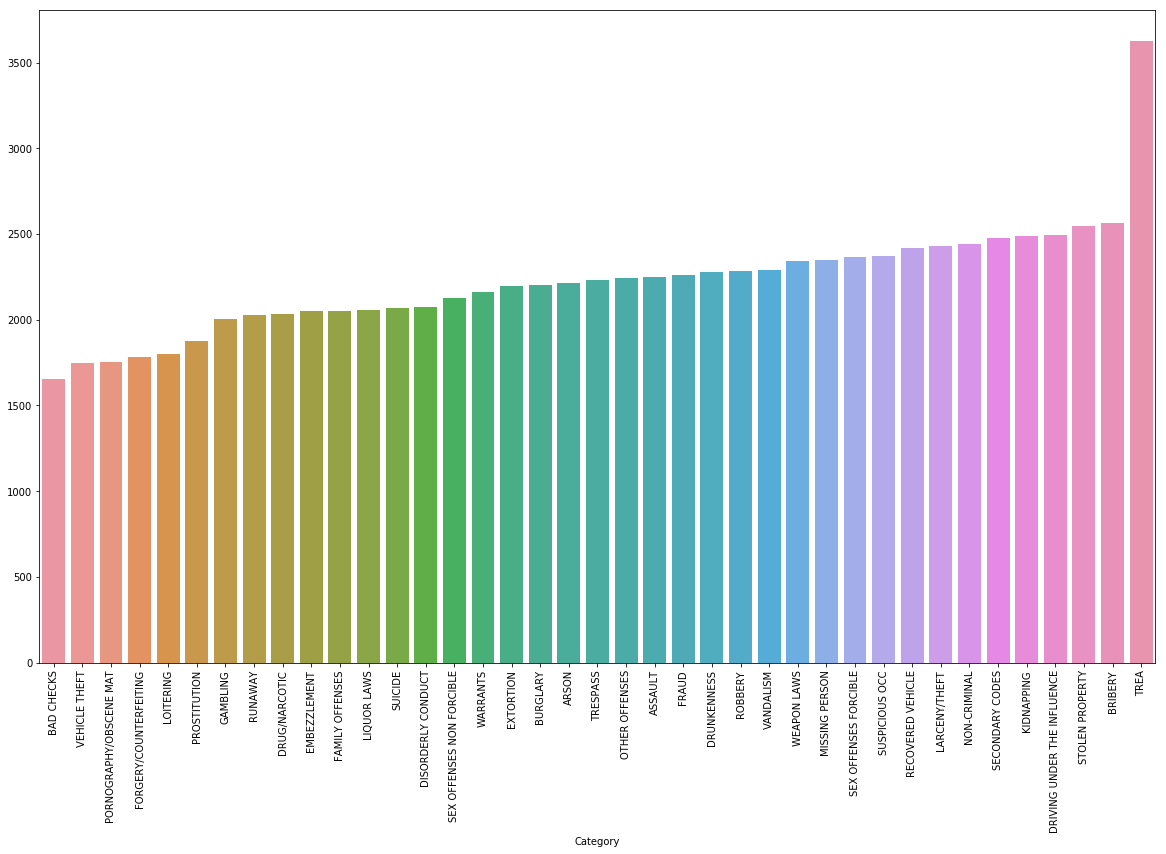

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
train.groupby("Category")["n_days"].mean().sort_values()
fig, ax = plt.subplots(1,1, figsize = (20,12))
sns.barplot(train.groupby("Category")["n_days"].mean().sort_values().index, train.groupby("Category")["n_days"].mean().sort_values().values)
plt.xticks(rotation=90)

In [42]:
#위도와 경도로 새로운 파생변수를 만듭시다.
#이 변수가 유의미한 이유? - 서로가 만들어내는 시너지를 트리모델 스스로 학습하지 못하므로 가로세로값의 시너지를 계산하기 위해 추가합니다.
# 빼고 더하면서 벡터의 각도, 방향이 추가되어서 효과가 있는 것 같다 (추측)
train["X_Y"] = train["X"] - train["Y"]
train["XY"] = train["X"] + train["Y"]

#####################피쳐엔지니어링 끝.

In [46]:
test.head()

,Dates,DayOfWeek,PdDistrict,Address,X,Y,Day,Month,Year,Hour,Minute
Id,,,,,,,,,,,
0,2015-05-10 23:59:00,6,0,6626,-122.399588,37.735051,10,5,2015,23,59
1,2015-05-10 23:51:00,6,0,10069,-122.391523,37.732432,10,5,2015,23,51
2,2015-05-10 23:50:00,6,4,6553,-122.426002,37.792212,10,5,2015,23,50
3,2015-05-10 23:45:00,6,2,10985,-122.437394,37.721412,10,5,2015,23,45
4,2015-05-10 23:45:00,6,2,10985,-122.437394,37.721412,10,5,2015,23,45


In [51]:
###불필요한 칼럼 제거

train.drop(['Dates','Date','Descript','Resolution', 'Category'], 1, inplace=True)
test.drop(['Dates','Date'], 1, inplace=True)



In [53]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(objective="multiclass", num_class=39, max_bin = 465, max_delta_step = 0.9,
                      learning_rate=0.4, num_leaves = 42, n_estimators=100,)
model.fit(train, y, categorical_feature=["PdDistrict", "DayOfWeek"])
#proba =probability 클래스마다의 확률이 나옴 (강도일 확률 60% 절도일 확률 20%) :  확률값으로 제출하는 이유 ? 너무 한가지로 과신해버리는 모델이 될수 있으므로
preds = model.predict_proba(test)
#learning rate 크면 발산해버릴 수도 있음. 그러나 크면 학습을 빠르게 할 수 있다는 장점, 작으면 수렵값에 가까워질 때 최적의 값을 지나치지 않고 섬세하게 접근 가능
#모델 학습속도에 가장 영향 주는 것으 나무의 갯수임
#categorical feature를 명시함. (address는 값이 너무 많아서 나무의 갯수 등 넣을게 너무 많아서 안 넣음)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['DayOfWeek', 'PdDistrict']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


ValueError: Number of features of the model must match the input. Model n_features_ is 13 and input n_features is 11 

In [ ]:
submission = pd.DataFrame(preds, columns=le2.inverse_transform(np.linspace(0, 38, 39, dtype='int16')), index=test.index)
submission.to_csv('LGBM_final.csv', index_label='Id')